# Property Rental Listings Analysis

# Install required packages

In [1]:
%pip install kaggle --upgrade

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 7, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 3.6 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



# Import libraries

In [4]:
import os
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from pyspark.sql import SparkSession

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 11, Finished, Available, Finished)

## Setup and Data Write

In [10]:
# Initialize Spark
spark = SparkSession.builder.getOrCreate()

# Configure Kaggle API
os.environ['KAGGLE_USERNAME'] = "mohanedm7md"
os.environ['KAGGLE_KEY'] = "39e5eb24572a19e188e04dfbdade648b"
from kaggle.api.kaggle_api_extended import KaggleApi
# Download dataset
api = KaggleApi()
api.authenticate()
api.dataset_download_file('jockeroika/properties-for-rent-online', 
                         file_name='listings 2 reduced.csv',
                         path='/lakehouse/default/Files/Kaggle task/')



Dataset URL: https://www.kaggle.com/datasets/jockeroika/properties-for-rent-online


/tmp/ipykernel_410/500635860.py:16: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/lakehouse/default/Files/Kaggle task/listings_2_reduced.csv')


# Load Data as pandas df

In [5]:
# Load data
df = pd.read_csv('/lakehouse/default/Files/Kaggle task/listings_2_reduced.csv')
df = df.drop_duplicates(subset="host_id", keep=False)
#the reason to load data as pandas first is dude bad spark csv file reading

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 12, Finished, Available, Finished)

/tmp/ipykernel_9874/618759774.py:2: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/lakehouse/default/Files/Kaggle task/listings_2_reduced.csv')


## Data Preparation as pandas

In [9]:
# Create Spark DataFrames
listing_df = spark.createDataFrame(df.loc[:, 'listing_url':'host_id'])
host_df = spark.createDataFrame(df.loc[:, 'host_id':'neighbourhood'])
spark_df = spark.createDataFrame(df)
#Saves table in the Lake house
listing_df.write.format("delta").mode("overwrite").saveAsTable("listingTable_spark")
host_df.write.format("delta").mode("overwrite").saveAsTable("hostTable")
# Clean price column
clean_df = spark_df.withColumn('price', F.substring('price', 2, 100).cast('float'))

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 16, Finished, Available, Finished)

## Analysis 1: Average Price

In [10]:
avgPrice = clean_df.agg(F.avg('price').alias("Average Price"))
display(avgPrice)

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5a4ca628-51bc-41ac-b342-fe8069790c97)

## Analysis 2: Top Neighborhoods

In [11]:
countTable = clean_df.groupBy('neighbourhood').count().dropna(subset=["neighbourhood"])
countTable.orderBy(F.desc('count')).first()

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 18, Finished, Available, Finished)

Row(neighbourhood='Greater London, England, United Kingdom', count=33337)

## Analysis 3: Most Reviewed Properties

## 

In [12]:
spark_df.orderBy(F.desc('number_of_reviews')).select('number_of_reviews').show()

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 19, Finished, Available, Finished)

+-----------------+
|number_of_reviews|
+-----------------+
|             1536|
|             1345|
|             1314|
|             1267|
|             1029|
|              934|
|              867|
|              856|
|              851|
|              847|
|              803|
|              800|
|              790|
|              775|
|              771|
|              764|
|              724|
|              711|
|              694|
|              685|
+-----------------+
only showing top 20 rows



## Visualization 1: Neighborhood Distribution

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 43, Finished, Available, Finished)

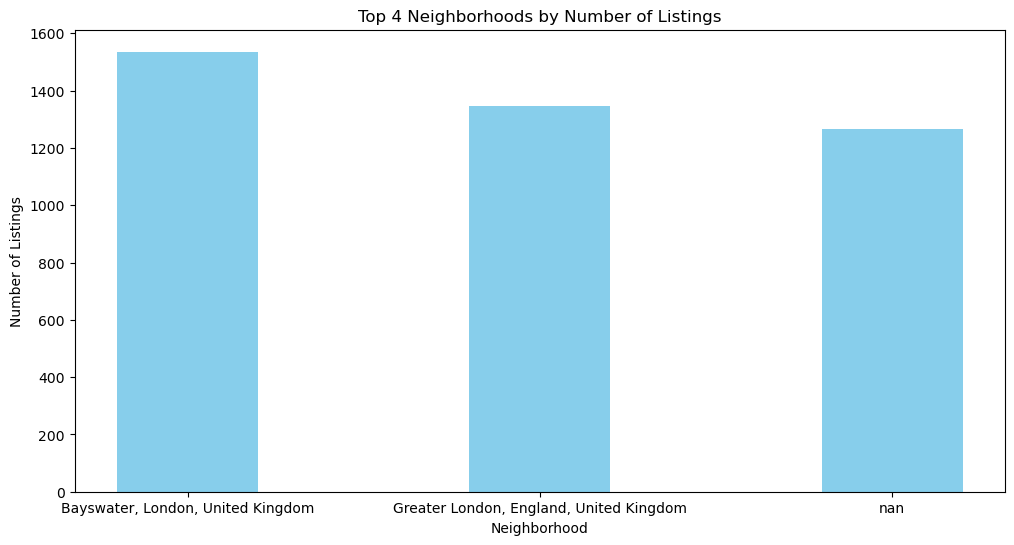

In [36]:
toPlt = df.sort_values(by='number_of_reviews', ascending=False).head(4)
plt.figure(figsize=(12, 6))
plt.bar(toPlt["neighbourhood"].astype(str), 
               toPlt["number_of_reviews"],
               color='skyblue',
               width=0.4)

plt.title("Top 4 Neighborhoods by Number of Listings")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Listings")
plt.show()


## Visualization 2: Geographic Heatmap

In [48]:
fig = px.density_mapbox(df, lat='latitude', lon='longitude',radius=10,
                        center=dict(lat=0, lon=180),
                           mapbox_style="open-street-map")
fig.show()

StatementMeta(, 3d6ff3e1-9e74-499f-aec0-c0b5f9283263, 55, Finished, Available, Finished)